# Initial guess algorithm in adiabatic quantum computing simulations
---

## Reading materials 
1. Quantum Optimization for Maximum Independent Set Using Rydberg Atom Arrays - Hannes Pichler
2. Lecture 32: Luby’s Algorithm for Maximal Independent Set - Gary Miller
3. A study of heuristic guesses for adiabatic quantum computation - Alejandro Perdomo-Ortiz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from guess_algorithm_helper import *
from random import randint


## Researched Algorithes

In this notebook I will compare 3 different approaches to solve MIS (Maximum independent sets):

### Normal - The known algorithm using Rydbeg atoms

We simply use the algorithm that's described by Hannes Pichler:
$$\begin{cases}
H_0 = \sum_{n=1}^NI - \sigma_x^n \\
H_p = -\Delta n_v \\
H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w
\end{cases}
$$

Using that we can build a full hamiltonian:
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$


### Heuristic Guess

As the name suggests we add a heuristic guesses for each vertex based on it's degree in the graph.

The new initial hamiltonian is as follows:
$$\tilde{H}_0 = \sum_{n=1}^{N}\left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \delta\sum_{n=1}^{N}\sigma_x^n$$

With $x_n$ being the guess:

$$x_n=\begin{cases}
1\rangle & & \frac{1}{dv} \geq C\\ 
0 \rangle & & \frac{1}{dv} < C
\end{cases}$$

and $\hat{q}_n$ is  $$\hat{q}_n = \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes \frac{1}{2}(\hat{I}-\sigma_z^n)\otimes \dots \otimes I_1$$


Finally $dv$ is the degree of vertex v, and constant $C \in [0,1]$ defines which vertex is assumed to start at ground and which is assumed to start at Rydberg. 

**_NOTE:_** We don't want divergance in out initial guess, which will happen if two adjacent vertex are drawn to Rydberg. For step I, our way to solve this is to set $C=1$. Meaning that only if the vertex is a leaf, it will start at Rydberg. Of course no two leafs are adjacent so no divergance will accure. 

In fact we can prove easly that all leafs can always be in the MIS. 
Assuming that there is a leaf v and an MIS G that doesn't contain v, since $G \cup v$ is a bigger graph and isn't the MIS, the vertex k that's connected to v must be in G. We can create a new graph $G'$ which is the same as G but with v instead of k. That is clearly also an MIS of same size.

### Our algorithm

As Adi suggested, using an initial setup on $|\psi_0 \rangle$ could result in better complexity.
As a follow up from the Heuristic Guess we can set it up as follows:
 $$|\psi_0 \rangle=\begin{cases}
|r\rangle & & \frac{1}{dv} \geq C\\ 
|g \rangle & & \frac{1}{dv} < C
\end{cases}$$

However since the corrent Hamiltonian aspires for grounds states at the start, we need to change it.
The algorithm we decided to test is:

$$H'_{tot} = (1-s)\sum_{n=1}^{N} \Delta_0 \left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \Omega(t)\delta\sum_{n=1}^{N}\sigma_x^n -s\Delta_0 n_v+H_{int}$$
---

## Parameters


### Defining usefull matrixs  

$$
\sigma_x = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} , \sigma_y = \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix} , \sigma_z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
 , 
|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
, |1\rangle  = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

And using them to define lists such as sz_list:
$$list = \sum_{n = 1}^{N} \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes \frac{1}{2}(\hat{I}-\sigma_z^n)\otimes \dots \otimes I_1$$

In [2]:
def generate_operators(N, num_states=2):
    """
    Generates useful quantum operators for a system of N states.

    Parameters:
    N (int): The number of states in the system.
    num_states (int): The dimension of the Hilbert space for each state (2 for qubits, 3 for qutrits, etc.).

    Returns:
    tuple: A tuple containing lists of tensor products of generalized operators.
           (sx_list, sz_list, one_list, I_N)
    """
    # Identity and Pauli-like operators for given number of states
    si = qeye(num_states)  # Identity matrix for a `num_states`-dimensional system

    # Define generalizations for Pauli matrices
    if num_states == 2:
        sx = sigmax()
        sz = sigmaz()
        one = basis(2, 1)  # |1><1| for qubit
    else:
        # Create placeholders for higher-dimensional operators
        sx = sigmax().full()[:num_states, :num_states]  # Truncate or expand sigmax as needed
        sz = sigmaz().full()[:num_states, :num_states]  # Truncate or expand sigmaz as needed
        one = basis(num_states, 1)  # |1><1| in higher dimensions

    # Initialize empty lists for storing operators
    sx_list = []
    sz_list = []
    one_list = []

    # Identity tensor for N states
    I_N = tensor([si] * N)

    # Generate the operators
    for n in range(N):
        # Initialize a list of identities for the tensor product
        op_list = [si] * N

        # Replace the n-th position with sx, sz, or |1><1|
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = 0.5 * (si - sz)
        sz_list.append(tensor(op_list))

        op_list[n] = one * one.dag()
        one_list.append(tensor(op_list))

    return sx_list, sz_list, one_list, I_N

### Hamiltonian parameters

Using page 4 of the article, we know the detuning ($\Delta(t)$) ,rabi frequency ($\Omega(t)$) and the rabi blockade radius($r_B$). 
$$\Delta(t) = \Delta_0 (2t/T-1)  $$
 $$ \Omega(t) = \Omega_0 sin^2(\pi t/T)$$
$$r_B = \left(C/\sqrt{(2\Omega)^2+\Delta^2}\right)^{1/6}$$

Where C is the interuction strength of rydberg atoms. We also use $\Omega_0 = 1$ and $\Delta_0/\Omega_0 = 6$.

To get the scale of the required T to finish the adiabatic transformation, we can look at different finish times:  
$$T = 5/\Omega_0 , 10/\Omega_0 ,\dots$$

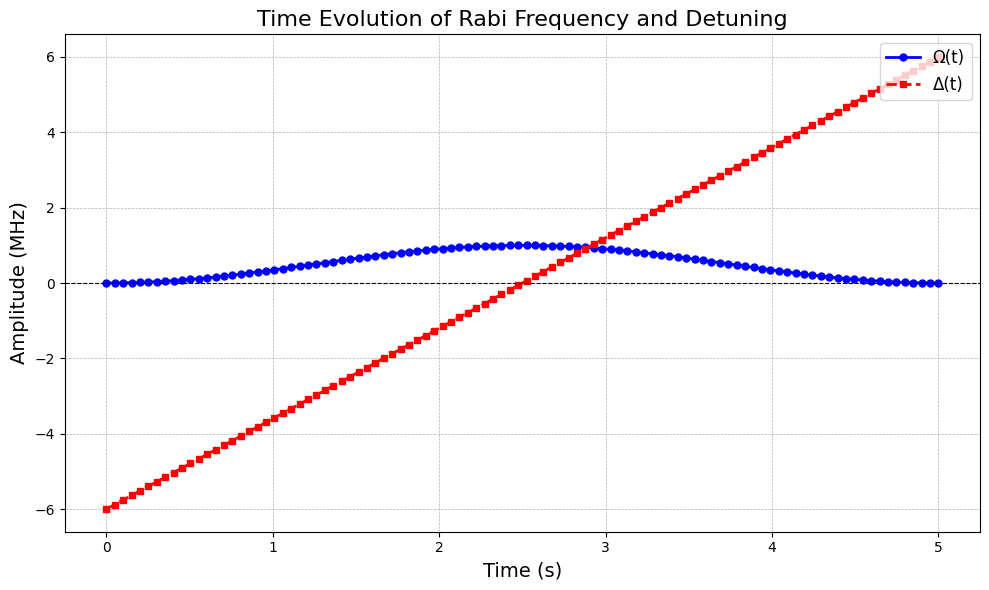

In [3]:
def initialize_system_parameters(delta=1.5, degree_min=1, omega_0 = 1, tau_max = 5, vertex_placement = 1):
    """
    Initializes the system parameters and returns the blockade radius, time-dependent 
    functions for Omega and Delta, and other constants.
    
    Parameters:
    delta (float): Power of driving Hamiltonian
    degree_min (float): Minimum degree threshold for the graph
    OMEGA_0 (float): Base Rabi frequency
    tau_max(float): in units of omega_0, the size of TAU_MAX
    vertex_placement(float): between 0 and 1, how close are vertexes to be placed near eachother.
                                      Note that this increases computation as it gets smaller. 
    
    Returns:
    dict: A dictionary containing time-dependent functions and system parameters
    """
    DELTA_0 = 6 / omega_0  # Initial detuning
    TAU_MAX = tau_max / omega_0  # Maximum time (in units of omega_0)
    INTERACTION_STRENGTH = 8.6 * omega_0  # Interaction strength constant

    # Calculate blockade radius
    blockade_radius = round((INTERACTION_STRENGTH * omega_0 / np.sqrt((2 * omega_0) ** 2 + DELTA_0 ** 2)) ** (1 / 6), 10)
    
    # Define time points for plotting
    taulist = np.linspace(0, TAU_MAX, 100)
    
    # Time-dependent Rabi frequency (Ω)
    def Omega(t):
        return omega_0 * np.sin(np.pi * t / TAU_MAX) ** 2
    
    # Time-dependent detuning (Δ)
    def Delta(t):
        return DELTA_0 * (2 * t / TAU_MAX - 1)
    
    # Return all parameters in a dictionary
    return {
        "OMEGA_0": omega_0,
        "DELTA_0": DELTA_0,
        "TAU_MAX": TAU_MAX,
        "INTERACTION_STRENGTH": INTERACTION_STRENGTH,
        "blockade_radius": blockade_radius,
        "vertex_placement": vertex_placement,
        "taulist": taulist,
        "Omega": Omega,
        "Delta": Delta,
        "delta": delta,
        "DEGREE_MIN": degree_min
    }

# Initialize system parameters
init_params = initialize_system_parameters(vertex_placement = 0.8)

# Example usage: Plotting the time evolution of Omega and Delta
timeEvoPlot(init_params["taulist"], init_params["Omega"], init_params["Delta"])

### Choosing a Graph

Since our system for checking complexity assumes there is little divergence, we use a chain graph as a basic test.

Note that in an actual system, another code needs to be written for transforming any graph to a real placement on the chip. Since this is not an easy code and isn't the basis of our research I am creating the graphs after we place them already.

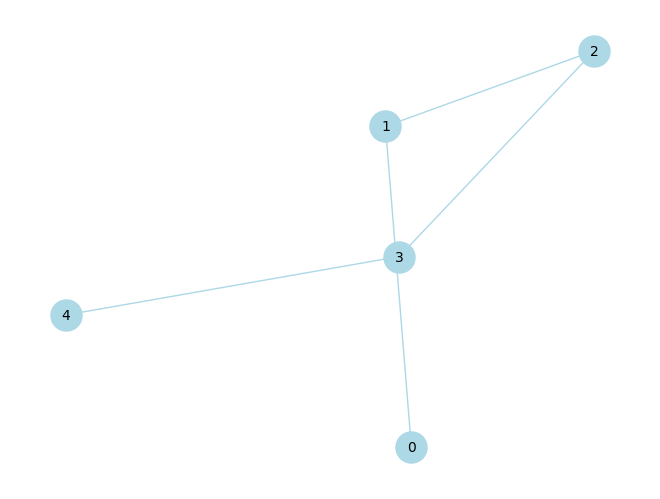

In [4]:
class BaseGraph:
    """Base class for graph generation."""
    
    def __init__(self, N):
        self.N = N
        self.graph = nx.Graph()
        self.pos = None  # Default position is None; subclasses can set it

    def plot_graph(self, ax=None, color = 'lightblue'):
        """Plots the generated graph on a given axis."""
        if self.pos is None:
            self.pos = nx.spring_layout(self.graph)  # Use spring layout if no position is set
        nx.draw(self.graph, pos=self.pos, with_labels=True, ax=ax, node_color=color, edge_color=color, node_size=500, font_size=10)
        if (ax != None):
            ax.set_title(self.__class__.__name__)  # Set title to class name

class ChainGraph(BaseGraph):
    """Class for generating a chain graph."""
    
    def __init__(self, N):
        super().__init__(N)

    def create_graph(self):
        """Creates a chain graph and adds edges based on blockade radius."""
        for i in range(N-1):
            self.graph.add_edge(i,i+1)



# Example usage:
N = 5  # Change N to test different cases
chain_graph = ChainGraph(N)
chain_graph.create_graph()
chain_graph.plot_graph()

### Construct the initial hamiltonians

The normal $H_0$ is based on the the existing algorithem:
$$H_0 = \sum_{n=1}^NI - \sigma_x^n$$

And the new $H_0$ is exacly the one described above. 


In [5]:
def default_guess_function(graph, node_index, degree_min):
    """Default guess function based on node degree."""
    if len(graph.degree)==2:
        return node_index==0
    return 1 / max(1, graph.degree[node_index]) >= degree_min

def initialize_states_and_hamiltonians(params, graph_instance, guess_func = default_guess_function, use_position=False):
    """
    Initializes the Hamiltonians and state vectors based on the graph properties.
    
    Parameters:
    params (dict): A dictionary of system parameters including DEGREE_MIN and delta.
    graph_instance (BaseGraph): An instance of the graph class (e.g., ChainGraph).
    guess_func (function): A function that generates a guess based on the node's properties.
    use_position (bool): Whether to use the graph's positional data for blockade radius calculation.

    Returns:
    tuple: (hamiltonians, psi_states)
    """
    delta = params['delta']
    degree_min = params['DEGREE_MIN']
    N = len(graph_instance.graph.nodes)  # Number of nodes in the graph
    sx_list, sz_list, one_list, I_N = generate_operators(N)

    # Classical Hamiltonian
    CL_H0 = I_N
    for n in range(N):
        CL_H0 -= sx_list[n]

    # Guess Hamiltonian
    GU_H0 = 0
    Hd = 0
    G = graph_instance.graph  # Ensure G is defined from the graph instance
    
    # Use the provided guess function to generate guesses
    guesses = [guess_func(G, n, degree_min) for n in range(N)]

    for n, guess in enumerate(guesses):
        GU_H0 += guess * I_N + sz_list[n] * (1 - 2 * guess)
        Hd += delta * sx_list[n]

    # State preparation using the precomputed guesses
    guess_psi_list = [basis(2, 1) if guess else basis(2, 0) for guess in guesses]
    classis_psi_list = [basis(2, 0) for _ in range(N)]
    guess_psi0 = tensor(guess_psi_list)
    classis_psi0 = tensor(classis_psi_list)

    Hp = 0
    H_int = 0
    for v in range(N):
        Hp -= one_list[v] 
        for w in range(v+1, N):
            if use_position:
                dist_x = G.nodes[v]['pos'][0] - G.nodes[w]['pos'][0]
                dist_y = G.nodes[v]['pos'][1] - G.nodes[w]['pos'][1]
                dist = np.sqrt(dist_x**2 + dist_y**2)
            else:
                dist = params["blockade_radius"]*params['vertex_placement'] if (v, w) in G.edges else params["blockade_radius"] * 3*(1/params['vertex_placement'])
            H_int += params["INTERACTION_STRENGTH"] / ((dist)**6) * one_list[v] * one_list[w]
    
    # Store Hamiltonians in a dictionary
    hamiltonians = {
        "classic": [[CL_H0 , params['Omega']], [Hp, params['Delta']], H_int],
        "setup": [[params['DELTA_0'] * GU_H0, lambda t: 1 - t / params['TAU_MAX']], 
                  [Hd, params['Omega']], 
                  [params['DELTA_0'] * Hp, lambda t: t / params['TAU_MAX']], H_int],
        "guess": [[GU_H0, params['Omega']], [Hd, params['Omega']], [Hp, params['Delta']], H_int]
    }

    # Store state vectors in a dictionary
    psi_states = {
        "guess": guess_psi0,
        "classical": classis_psi0
    }
    
    return hamiltonians, psi_states

hamiltonians, psi_states = initialize_states_and_hamiltonians(init_params, chain_graph)

### Construct evolution Hamiltonian
This code segment initializes and calculates the Hamiltonian for a system of \(N\) Rydberg atoms arranged in a two-dimensional space. 
$$H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w$$
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$

In [6]:
def solve_hamiltonians(hamiltonians, psi_states, params):
    """
    Transforms Hamiltonians to QobjEvo and solves them using the Schrödinger equation.

    Parameters:
    hamiltonians (dict): A dictionary containing Hamiltonians as arrays.
                         Example: hamiltonians["classic"], hamiltonians["guess"], hamiltonians["setup"]
    psi_states (dict): A dictionary containing initial state vectors.
                       Example: psi_states["classical"], psi_states["guess"]
    params (dict): A dictionary of parameters, including 'taulist'.

    Returns:
    tuple: Two dictionaries - one for Hamiltonians and one for results from solving the Hamiltonians.
    """
    
    # Extract parameters
    taulist = params['taulist']

    # Transform Hamiltonians to QobjEvo
    classic_h_t = QobjEvo(hamiltonians["classic"])
    classic_result = sesolve(classic_h_t, psi_states["classical"], taulist, [], {})

    guess_h_t = QobjEvo(hamiltonians["guess"])
    guess_result = sesolve(guess_h_t, psi_states["classical"], taulist, [], {})

    setup_h_t = QobjEvo(hamiltonians["setup"])
    setup_result = sesolve(setup_h_t, psi_states["guess"], taulist, [], {})

    # Return Hamiltonians and results in separate dictionaries
    hamiltonians_out = {
        "classic": classic_h_t,
        "guess": guess_h_t,
        "setup": setup_h_t,
    }

    results_out = {
        "classic": classic_result,
        "guess": guess_result,
        "setup": setup_result,
    }

    return hamiltonians_out, results_out

# Call the function and unpack results
hamiltonians_out, results_out = solve_hamiltonians(hamiltonians, psi_states, init_params)

## Results analysis

### Minimal gap 

In MIS usually a miniamal gap is not a good indication of complexity since there will be divergence. However in simple chain graphs it can still be an indication.

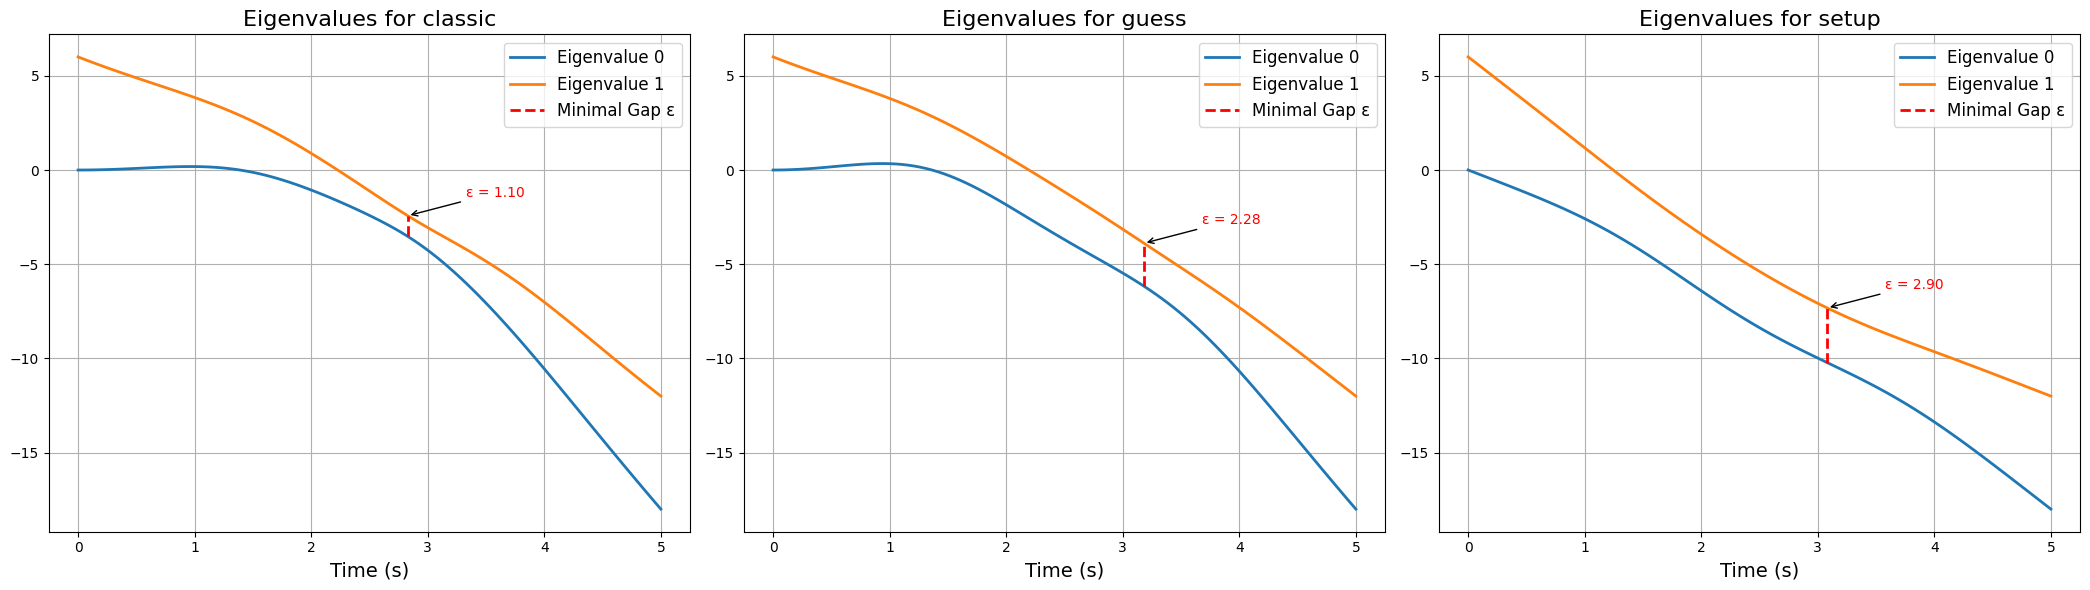

In [7]:
def plot_eigenvalues(taulist, hamiltonians, N, M=2):
    """Plots eigenvalues for the given Hamiltonians over time in a compact format."""
    eigenvalues = {key: np.zeros((len(taulist), 2**N)) for key in hamiltonians.keys()}

    for key in hamiltonians:
        for i, t in enumerate(taulist):
            H = hamiltonians[key](t)
            eigenvalues[key][i, :] = H.eigenenergies()

    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    for ax, key in zip(axs, hamiltonians.keys()):
        for m in range(M):
            ax.plot(taulist, eigenvalues[key][:, m], label=f"Eigenvalue {m}", linewidth=2)

        lowest_eigenvalues = eigenvalues[key][:, :2]
        gap_values = lowest_eigenvalues[:, 1] - lowest_eigenvalues[:, 0]
        epsilon = np.min(gap_values)
        gap_time_index = np.argmin(gap_values)

        ax.plot([taulist[gap_time_index]] * 2,
                [lowest_eigenvalues[gap_time_index, 0], lowest_eigenvalues[gap_time_index, 1]],
                color='red', linestyle='--', linewidth=2, label='Minimal Gap ε')

        ax.annotate(f'ε = {epsilon:.2f}', 
                     xy=(taulist[gap_time_index], lowest_eigenvalues[gap_time_index, 0] + epsilon),
                     xytext=(taulist[gap_time_index] + 0.5, lowest_eigenvalues[gap_time_index, 0] + epsilon + 1),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='red')

        ax.set_title(f'Eigenvalues for {key}', fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_eigenvalues(init_params["taulist"], hamiltonians_out,N, M=2)

And clearly Our hamiltonian was the best :)

### States comparing
I gave the sytem a small time frame for the problem. Hence no algorithm is done solving it yet. Using that we can see the difference in how each of them works.

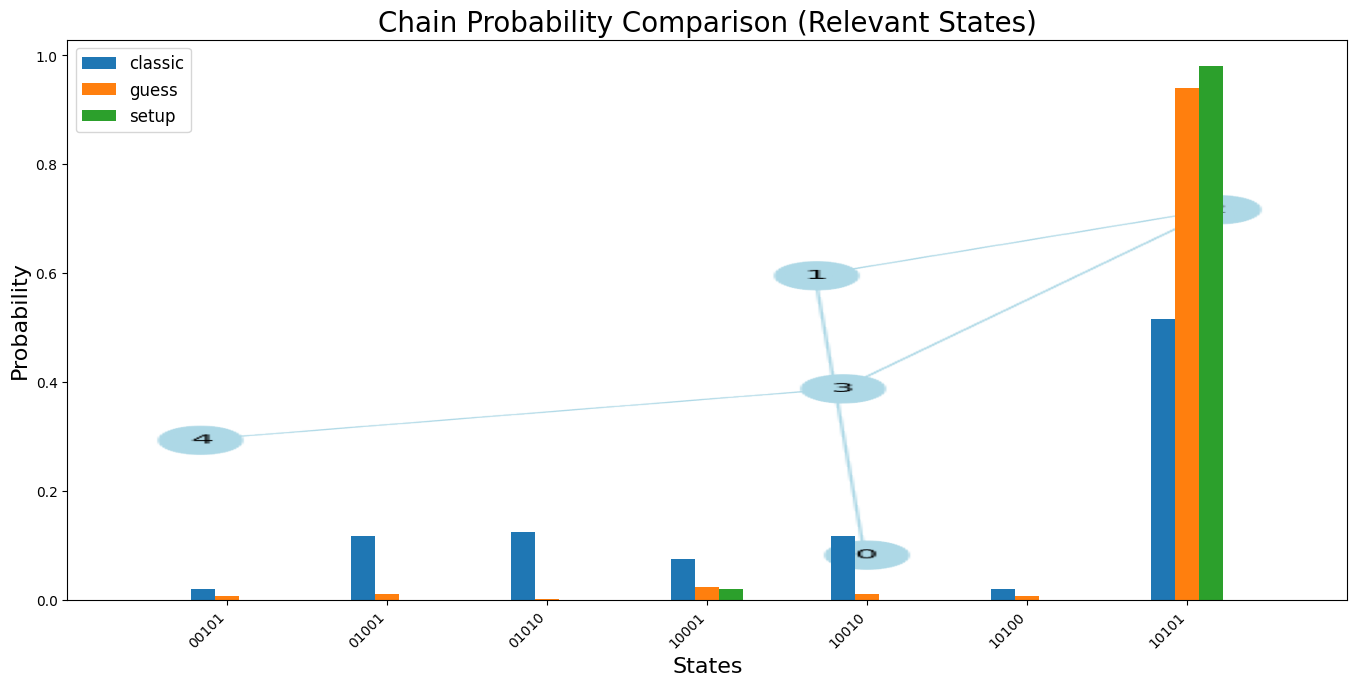

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from io import BytesIO

def get_background_image(background_graph):
    """Creates a background image from the graph without saving to disk."""
    fig, ax = plt.subplots(figsize=(6, 6))  # Create a temporary figure
    background_graph.plot_graph()  # Use the existing plot_graph method to draw
    plt.axis('off')  # Turn off the axis

    # Save the figure to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, bbox_inches='tight', transparent=True)  # Save as PNG to the buffer
    plt.close(fig)  # Close the figure
    buf.seek(0)  # Rewind the buffer
    return buf  # Return the buffer containing the image

def plot_probabilities(results_out, psi_states, N, graph_type, graph=None, threshold=0.1):
    """
    Plots the initial and final state probabilities for the given results.

    Parameters:
    results_out (dict): Dictionary containing results for the different Hamiltonians.
    psi_states (dict): Dictionary containing initial state vectors.
    N (int): Number of qubits/nodes in the graph.
    graph_type (str): Type of graph being plotted (e.g., "Final States", "Initial States").
    threshold (float): Threshold for probability filtering.
    """
    # Define the digits and generate all combinations of states
    digits = [0, 1]
    combinations = product(digits, repeat=N)
    lst = [''.join(map(str, combination)) for combination in combinations]

    # Extract coefficients for final states for all results
    coeff_final = {
        key: [np.abs(a_i[0])**2 for a_i in value.states[-1].full()]
        for key, value in results_out.items()
    }

    # Identify relevant states with probabilities above the threshold
    relevant_indices = set()
    for key, coeffs in coeff_final.items():
        # Find indices with probabilities above the threshold
        above_threshold_indices = np.where(np.array(coeffs) > threshold)[0]
        relevant_indices.update(above_threshold_indices)

    # If no relevant states, return early
    if not relevant_indices:
        print("No relevant states to plot.")
        return

    # Filter the relevant states
    relevant_indices = sorted(relevant_indices)  # Sort the indices
    relevant_states = [lst[i] for i in relevant_indices]  # Get corresponding state labels
    relevant_coeff_final = {key: [coeffs[i] for i in relevant_indices] for key, coeffs in coeff_final.items()}  # Filter coefficients

    # Create x positions for the bars based on relevant states
    x = np.arange(len(relevant_states))  # X positions for the bar graph

    # Create a larger figure
    plt.figure(figsize=(16, 8))  # Reasonable figure size for better visibility
    ax = plt.gca()

    # Plot background image if provided
    if graph is not None:
        image = plt.imread(get_background_image(graph))  # Load the image from the buffer
        ax.imshow(image, aspect='auto', extent=[-1, len(relevant_states), 0, 0.8], alpha=1)  # Place the image in the background

    # Set limits for the main plot area
    ax.set_xlim(-1, len(relevant_states))  # Extend x limits to accommodate the bar graph

    # Plot final states for relevant states
    for i, (label, coeffs) in enumerate(relevant_coeff_final.items()):
        bar_width = 0.15  # Width of each bar
        ax.bar(x + (i - 1) * bar_width, coeffs, width=bar_width, label=label)

    # Incorporate graph_type into the title
    plt.title(f'{graph_type} Probability Comparison (Relevant States)', fontsize=20)  # Increased title font size
    ax.set_xlabel('States', fontsize=16)  # Increased axis label font size
    ax.set_ylabel('Probability', fontsize=16)  # Increased axis label font size

    # Set x ticks for all relevant states
    ax.set_xticks(x)  # Show all relevant state options
    ax.set_xticklabels(relevant_states, rotation=45, ha='right', fontsize=10)  # Adjust font size and rotate

    ax.legend(loc='upper left', fontsize=12)  # Legend font size

    # Adjust subplots to allow for more space around the edges
    plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)  # Custom adjustments

    plt.show()

# Call the function with the appropriate parameters, including the graph type
plot_probabilities(results_out, psi_states, N, graph_type="Chain", graph=chain_graph, threshold=0.01)


---
# A proper guess function
We can use a greedy algorithm to build an independent set in polynomial time.

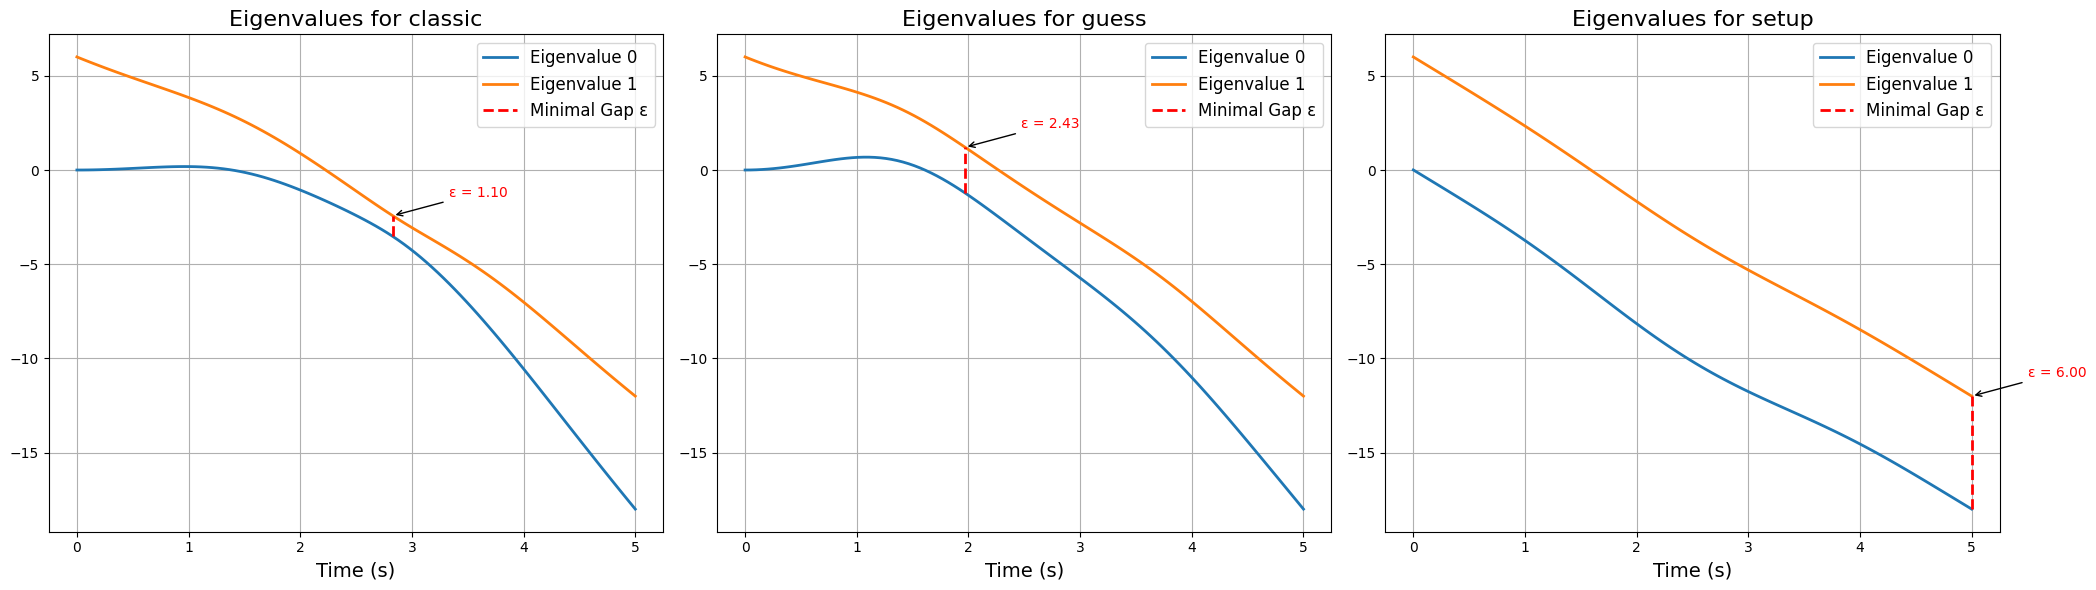

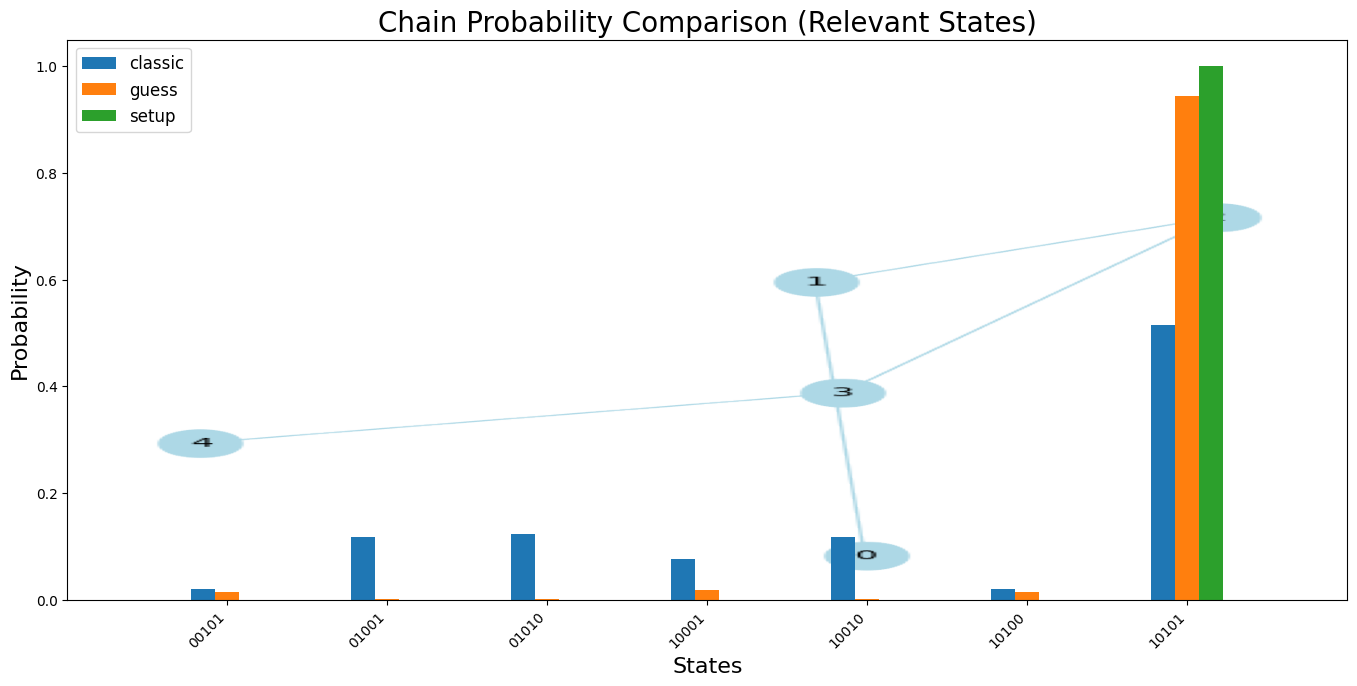

In [9]:
def greedy_independent_set(graph, degree_min):
    """
    Greedy algorithm to check if the given node is part of the independent set,
    considering the degree_min constraint.

    Parameters:
    graph (networkx.Graph): A NetworkX graph instance.
    node_index (int): The index of the node being checked.
    degree_min (float): The minimum degree a node must have to be considered.

    Returns:
    bool: True if the node is part of the independent set and satisfies degree_min, False otherwise.
    """
    independent_set = set()
    remaining_nodes = list(graph.nodes)
    
    # Greedy independent set construction
    while remaining_nodes:
        # Pick the first node from the remaining nodes
        node = remaining_nodes.pop(0)
        
        # Check if the node's degree satisfies the degree_min constraint
        if max(1, graph.degree[node]) >= degree_min:
            independent_set.add(node)
            
            # Remove all its neighbors from the remaining nodes
            neighbors = list(graph.neighbors(node))
            remaining_nodes = [n for n in remaining_nodes if n not in neighbors]
    
    # Return whether the specific node is in the independent set
    return independent_set

def greedy_guess(graph, node_index, degree_min):
    return node_index in greedy_independent_set(graph,degree_min)


hamiltonians, psi_states = initialize_states_and_hamiltonians(init_params, chain_graph, guess_func=greedy_guess)
hamiltonians_out, results_out = solve_hamiltonians(hamiltonians, psi_states, init_params)
plot_eigenvalues(init_params["taulist"], hamiltonians_out,N, M=2)
plot_probabilities(results_out, psi_states, N, graph_type="Chain", graph=chain_graph, threshold=0.01)


---
# final points 

Clearly in simple cases we can see our solution helps. From now on the greedy guess will be used because it seems to be the better of the two. As a follow up we need to use another system instead of minimal gaps which will allow us to check a collection of graphs instead of testing them in an anecdotal way. 

In addition, the constants for the new hamiltonians were not optimized. Specificly the usage of $\delta$ and $\Delta_0$ in the final hamiltonian was a guess and is assumed to be improvable.

### Bad states probability 

The bad states are directly affected by the distance between the vertexes. We want the probability to be below a threshhold which seems fit. 


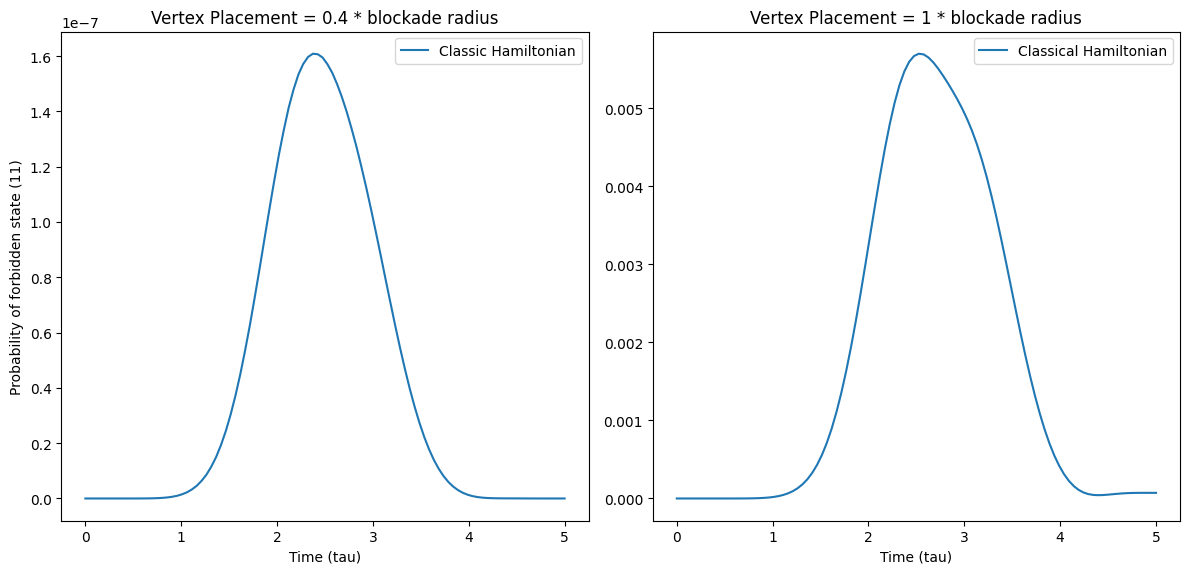

In [10]:
import matplotlib.pyplot as plt

# Function to track forbidden state probability over time
def track_forbidden_state(results_out, state_index):
    """
    Track the probability of a forbidden state over time.

    Parameters:
    - results_out: Dictionary with time-evolved state vectors
    - state_index: Index of the forbidden state (e.g., '11')
    
    Returns:
    - forbidden_probs: Dictionary with probabilities over time for each Hamiltonian type
    """
    forbidden_probs = {}
    
    # Loop through each type of Hamiltonian result (e.g., 'classical', 'guess', 'setup')
    for key, result in results_out.items():
        forbidden_probs[key] = []
        
        # Loop over all time steps
        for time_step in result.states:
            # Get the probability amplitude of the forbidden state at the current time step
            prob = np.abs(time_step.full()[state_index][0])**2  # Extract amplitude for the specific state
            forbidden_probs[key].append(prob)
    
    return forbidden_probs

# Simulation for vertex_placement = 0.4
init_params_0_4 = initialize_system_parameters(vertex_placement=0.4)
chain_graph_0_4 = ChainGraph(2)
chain_graph_0_4.create_graph()
hamiltonians_0_4, psi_states_0_4 = initialize_states_and_hamiltonians(init_params_0_4, chain_graph_0_4, guess_func=greedy_guess)
hamiltonians_out_0_4, results_out_0_4 = solve_hamiltonians(hamiltonians_0_4, psi_states_0_4, init_params_0_4)
forbidden_probabilities_0_4 = track_forbidden_state(results_out_0_4, state_index=3)  # Track state '11'

# Simulation for vertex_placement = 1
init_params_1 = initialize_system_parameters(vertex_placement=1)
chain_graph_1 = ChainGraph(2)
chain_graph_1.create_graph()
hamiltonians_1, psi_states_1 = initialize_states_and_hamiltonians(init_params_1, chain_graph_1, guess_func=greedy_guess)
hamiltonians_out_1, results_out_1 = solve_hamiltonians(hamiltonians_1, psi_states_1, init_params_1)
forbidden_probabilities_1 = track_forbidden_state(results_out_1, state_index=3)  # Track state '11'

# Plot the results side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for vertex_placement = 0.4
ax1.plot(init_params_0_4['taulist'], forbidden_probabilities_0_4['classic'], label='Classic Hamiltonian')
ax1.set_title('Vertex Placement = 0.4 * blockade radius')
ax1.set_xlabel('Time (tau)')
ax1.set_ylabel('Probability of forbidden state (11)')
ax1.legend()

# Plot for vertex_placement = 1
ax2.plot(init_params_1['taulist'], forbidden_probabilities_1['classic'], label='Classical Hamiltonian')
ax2.set_title('Vertex Placement = 1 * blockade radius')
ax2.set_xlabel('Time (tau)')
ax2.legend()

plt.tight_layout()  # Adjust spacing
plt.show()